<blockquote>
    <h1>Exercise 8.11</h1>
    <p>This question uses the <code>Caravan</code> data set.</p>
    <ol>
        <li>Create a training set consisting of the first $1000$ observations, and a test set consisting of the remaining observations.</li>
        <li>Fit a boosting model to the training set with $\mathrm{Purchase}$ as the response and the other variables as predictors. Use $1000$ trees, and a shrinkage value of $0.01$. Which predictors appear to be the most important?</li>
        <li>Use the boosting model to predict the response on the test data. Predict that a person will make a purchase if the estimated probability of purchase is greater than $20\%$. Form a confusion matrix. What fraction of the people predicted to make a purchase do in fact make one? How does this compare with the results obtained from applying KNN or logistic regression to this data set?</li>
    </ol>
</blockquote>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder  # https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv("../../DataSets/Caravan/Caravan.csv", index_col = 0)
df.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
1,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
3,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
4,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
5,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


In [3]:
# Convert categorical independent data using one hot encoding:
# which takes a column with categorical data and 
# then splits the column into multiple columns. 
# The numbers are replaced by 1s and 0s, depending 
# on which column has what value. 
categorical_lst = ['MOSTYPE', 'MOSHOOFD']
columns = df.columns.tolist()
indices = [index for index, column in enumerate(columns) if column in categorical_lst]

onehotencoder = OneHotEncoder()
categorical_transformed = onehotencoder.fit_transform(df[categorical_lst]).toarray()
    
new_categorical_lst = []
for categorical_name, np_arr in zip(categorical_lst, onehotencoder.categories_):
    temp_lst = [f'{categorical_name} ({category})' for category in np_arr]
    new_categorical_lst.extend(temp_lst)
    
df_categorical_transformed = pd.DataFrame(categorical_transformed, 
                                          columns=new_categorical_lst, 
                                          index=df.index,
                                          dtype='int64')
for column in new_categorical_lst:
    df_categorical_transformed[column] = df_categorical_transformed[column].astype('category')

df_transformed = pd.concat([df.drop(categorical_lst, 1), df_categorical_transformed], axis=1)
df_transformed.head()

,MAANTHUI,MGEMOMV,MGEMLEEF,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,...,MOSHOOFD (1),MOSHOOFD (2),MOSHOOFD (3),MOSHOOFD (4),MOSHOOFD (5),MOSHOOFD (6),MOSHOOFD (7),MOSHOOFD (8),MOSHOOFD (9),MOSHOOFD (10)
1,1,3,2,0,5,1,3,7,0,2,...,0,0,0,0,0,0,0,1,0,0
2,1,2,2,1,4,1,4,6,2,2,...,0,0,0,0,0,0,0,1,0,0
3,1,2,2,0,4,2,4,3,2,4,...,0,0,0,0,0,0,0,1,0,0
4,1,3,3,2,3,2,4,5,2,2,...,0,0,1,0,0,0,0,0,0,0
5,1,4,2,1,4,1,4,7,1,2,...,0,0,0,0,0,0,0,0,0,1


<h3>Exercise 8.11.1</h3>
<blockquote>
    <i>Create a training set consisting of the first $1000$ observations, and a test set consisting of the remaining observations.</i>
</blockquote>

In [4]:
df_y = df_transformed[['Purchase']]
df_x = df_transformed.drop('Purchase', 1)
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    df_x, 
    df_y, 
    train_size=1000, 
    random_state=42
)

<h3>Exercise 8.11.2</h3>
<blockquote>
    <i>Fit a boosting model to the training set with $\mathrm{Purchase}$ as the response and the other variables as predictors. Use $1000$ trees, and a shrinkage value of $0.01$. Which predictors appear to be the most important?</i>
</blockquote>

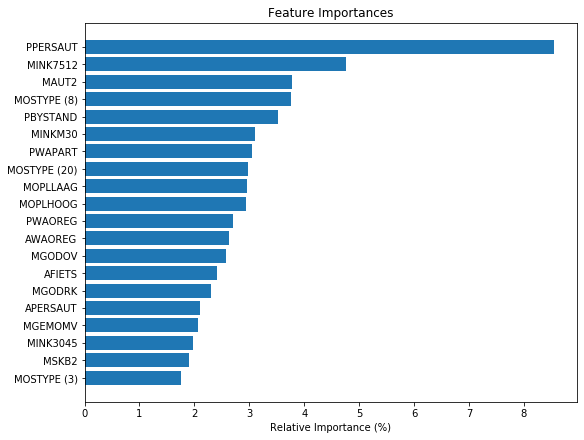

In [5]:
boosting_reg = GradientBoostingClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    random_state=42
)
_ = boosting_reg.fit(df_x_train, df_y_train['Purchase'])

importances = 100 * boosting_reg.feature_importances_
indices = np.argsort(importances)
most_important = indices[-20:]
columns = df_x.columns.tolist()

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6))

_ = ax.barh(range(len(most_important)), importances[most_important], align='center')
_ = ax.set_yticklabels([columns[i] for i in most_important])
_ = ax.set_yticks(range(len(most_important)))
_ = ax.set_xlabel('Relative Importance (%)')
_ = ax.set_title('Feature Importances')

<h3>Exercise 8.11.3</h3>
<blockquote>
    <i>Use the boosting model to predict the response on the test data. Predict that a person will make a purchase if the estimated probability of purchase is greater than $20\%$. Form a confusion matrix. What fraction of the people predicted to make a purchase do in fact make one? How does this compare with the results obtained from applying KNN or logistic regression to this data set?</i>
</blockquote>

In [6]:
y_pred = boosting_reg.predict_proba(df_x_test)
threshold = 0.2
df_y_pred = pd.DataFrame({'predicted': np.where(y_pred[:, 1] > threshold, 'Yes', 'No')},
                        index=df_y_test.index)

mask_true_positive = df_y_test['Purchase'] == 'Yes'
count_positives = df_y_pred['predicted'][mask_true_positive].value_counts()
false_negative = count_positives.loc['No']
true_positive = count_positives.loc['Yes']

count_negatives = df_y_pred['predicted'][~mask_true_positive].value_counts()
true_negative = count_negatives.loc['No']
false_positive = count_negatives.loc['Yes']

index = pd.MultiIndex.from_tuples([('actual', 'No'), ('actual', 'Yes')])
columns = pd.MultiIndex.from_tuples([('predicted', 'No'), ('predicted', 'Yes')])
cm = pd.DataFrame([
    [true_negative, false_positive], 
    [false_negative, true_positive]
], columns=columns, index=index)
cm

predicted     
                  No  Yes
actual No       4347  187
       Yes       244   44

In [7]:
true_negative_rate = true_negative / (true_negative + false_positive)
false_positive_rate = false_positive / (true_negative + false_positive)
false_negative_rate = false_negative / (true_positive + false_negative)
true_positive_rate = true_positive / (true_positive + false_negative)
confusion_pct = 100 * np.array([
    [true_negative_rate, false_positive_rate],
    [false_negative_rate, true_positive_rate]
])
index_pct = pd.MultiIndex.from_tuples([('actual (%)', 'No'), ('actual (%)', 'Yes')])
columns_pct = pd.MultiIndex.from_tuples([('predicted (%)', 'No'), ('predicted (%)', 'Yes')])
cm_pct = pd.DataFrame(confusion_pct, columns=columns_pct, index=index_pct)
cm_pct.round(2)

predicted (%)       
                          No    Yes
actual (%) No          95.88   4.12
           Yes         84.72  15.28

<p>Let us compare these results with a logistic regression.<p>

In [8]:
log_reg = LogisticRegression(max_iter=1000)
y_train_binary = np.squeeze(np.where(df_y_train == 'Yes', 1, 0))
_ = log_reg.fit(df_x_train, y_train_binary)

y_pred = log_reg.predict_proba(df_x_test)
threshold = 0.2
df_y_pred = pd.DataFrame({'predicted': np.where(y_pred[:, 1] > threshold, 'Yes', 'No')},
                        index=df_y_test.index)

mask_true_positive = df_y_test['Purchase'] == 'Yes'
count_positives = df_y_pred['predicted'][mask_true_positive].value_counts()
false_negative = count_positives.loc['No']
true_positive = count_positives.loc['Yes']

count_negatives = df_y_pred['predicted'][~mask_true_positive].value_counts()
true_negative = count_negatives.loc['No']
false_positive = count_negatives.loc['Yes']

index = pd.MultiIndex.from_tuples([('actual', 'No'), ('actual', 'Yes')])
columns = pd.MultiIndex.from_tuples([('predicted', 'No'), ('predicted', 'Yes')])
cm = pd.DataFrame([
    [true_negative, false_positive], 
    [false_negative, true_positive]
], columns=columns, index=index)
cm

predicted     
                  No  Yes
actual No       4244  290
       Yes       231   57

In [9]:
true_negative_rate = true_negative / (true_negative + false_positive)
false_positive_rate = false_positive / (true_negative + false_positive)
false_negative_rate = false_negative / (true_positive + false_negative)
true_positive_rate = true_positive / (true_positive + false_negative)
confusion_pct = 100 * np.array([
    [true_negative_rate, false_positive_rate],
    [false_negative_rate, true_positive_rate]
])
index_pct = pd.MultiIndex.from_tuples([('actual (%)', 'No'), ('actual (%)', 'Yes')])
columns_pct = pd.MultiIndex.from_tuples([('predicted (%)', 'No'), ('predicted (%)', 'Yes')])
cm_pct = pd.DataFrame(confusion_pct, columns=columns_pct, index=index_pct)
cm_pct.round(2)

predicted (%)       
                          No    Yes
actual (%) No          93.60   6.40
           Yes         80.21  19.79

<p>Finally we also apply a KNN to the data set.<p>

In [10]:
knn = KNeighborsClassifier(n_neighbors=50)
_ = knn.fit(df_x_train, df_y_train.squeeze())

y_pred = knn.predict_proba(df_x_test)
threshold = 0.2
df_y_pred = pd.DataFrame({'predicted': np.where(y_pred[:, 1] > threshold, 'Yes', 'No')},
                        index=df_y_test.index)

mask_true_positive = df_y_test['Purchase'] == 'Yes'
count_positives = df_y_pred['predicted'][mask_true_positive].value_counts()
false_negative = count_positives.loc['No']
true_positive = count_positives.loc['Yes']

count_negatives = df_y_pred['predicted'][~mask_true_positive].value_counts()
true_negative = count_negatives.loc['No']
false_positive = count_negatives.loc['Yes']

index = pd.MultiIndex.from_tuples([('actual', 'No'), ('actual', 'Yes')])
columns = pd.MultiIndex.from_tuples([('predicted', 'No'), ('predicted', 'Yes')])
cm = pd.DataFrame([
    [true_negative, false_positive], 
    [false_negative, true_positive]
], columns=columns, index=index)
cm

predicted    
                  No Yes
actual No       4473  61
       Yes       277  11

In [11]:
true_negative_rate = true_negative / (true_negative + false_positive)
false_positive_rate = false_positive / (true_negative + false_positive)
false_negative_rate = false_negative / (true_positive + false_negative)
true_positive_rate = true_positive / (true_positive + false_negative)
confusion_pct = 100 * np.array([
    [true_negative_rate, false_positive_rate],
    [false_negative_rate, true_positive_rate]
])
index_pct = pd.MultiIndex.from_tuples([('actual (%)', 'No'), ('actual (%)', 'Yes')])
columns_pct = pd.MultiIndex.from_tuples([('predicted (%)', 'No'), ('predicted (%)', 'Yes')])
cm_pct = pd.DataFrame(confusion_pct, columns=columns_pct, index=index_pct)
cm_pct.round(2)

predicted (%)      
                          No   Yes
actual (%) No          98.65  1.35
           Yes         96.18  3.82